<a href="https://colab.research.google.com/github/joangoma/practiques_aa2/blob/main/12_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN + conditional DCGAN


Notebook created by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) for the [Postgraduate course in artificial intelligence with deep learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) in [UPC School](https://www.talent.upc.edu/ing/) (2020). Updated by [Mariona Carós](https://es.linkedin.com/in/mariona-c-a7bb91105) in 2022.
Minor contributions by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) and [Juan José Nieto](https://www.linkedin.com/in/juan-jose-nieto-salas/) during 2022.

In this notebook you will learn about Generative Adversarial Networks by implementing a DCGAN to generate images from noise.

**Important:** Set the Colab environment to run on GPU

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, utils
from PIL import Image
import numpy as np
import math
from IPython.display import display
from tqdm import tqdm
from itertools import cycle
from typing import Tuple

In [ ]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Defining the Hyper-parameters**

We now define the hyperparameters that are going to be used throughout the notebook to define the network.


In [ ]:
hparams = {
    'batch_size':128,
    'num_epochs':20,
    'learning_rate':0.0002,
    'betas':(0.5, 0.999),
    'noise_size':100,
    'num_val_samples':25,
    'num_classes':10,
    'num_input_channels':1,
}

### Dataset and Data Loader
Download and prepare dataset and datalaoder


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=train_transforms,
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=hparams['batch_size'],
    shuffle=True,
)

# DCGAN

First, lets define our simple generator network.

### Exercise 1: Generator

The generator takes random noise as input and gives an image as output. Your exercise is to create the generator model.

It should follow these guidelines:
* The input will be a vector with random noise of size `noise_size`
* You should first apply a fully connected with output size 512\*4\*4 (channels\*height\*width)
* Then you should apply 3 blocks of:
    * TransposedConvolution with kernel size 4, stride 2 and padding 1. For the first 2 blocks, the output channels should be 256 and 128. For the third block, the output channels should be the correct one to generate images of the dataset.
    * BatchNorm2d except for the last block.
    * ReLU activation for the first 2 blocks and Tanh for the third block.

**Hint**: Remember to use reshape where necessary

In [ ]:
class Generator(torch.nn.Module):

    def __init__(self, noise_size: int, num_input_channels: int):
        super().__init__()

        # TODO: Create the Fully connected layer using nn.Linear
        self.fc = nn.Linear(noise_size, 512*4*4, bias=False)

        # TODO: Create the first block
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # TODO: Create the second block
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # TODO: Create the third block using nn.Sequential with ConvTranspose2d, and activation
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,out_channels=num_input_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), # (B, num_input_channels, 32, 32)
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.fc(x)
        # Reshape to (B, 512, 4, 4)
        x = x.reshape(-1, 512, 4, 4)
        x = self.convt1(x)  # (B, 256, 8, 8)
        x = self.convt2(x)  # (B, 128, 16, 16)
        x = self.convt3(x)  # (B, num_input_channels, 32, 32)

        return x

Similarly, let's define a simple discriminator

### Exercise 2: Discriminator

The discriminator takes an image as input and classifies it between Real or Fake (1 or 0). Your exercise is to create the discriminator model.

It should follow these guidelines:
* The input will be an image of size `[num_input_channels, 32, 32]`
* You should apply 3 blocks of:
    * Convolution with kernel size 4, stride 2 and padding 1. The output channels should be 128, 256 and 512.
    * BatchNorm2d except for the first block.
    * LeakyReLU activation (alpha=0.2)
* Then you should apply a fully connected with input size 512\*4\*4 (channels\*height\*width) and the correct output size and activation for binary classification


**Hint**: Remember to use reshape/flatten where necessary

In [ ]:
class Discriminator(torch.nn.Module):

    def __init__(self, num_input_channels: int):
        super().__init__()

        # TODO: Create the first block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=num_input_channels, out_channels=128, kernel_size=4,stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the third block
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                out_channels=512,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), # (B, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the fully connected block using nn.Sequential with Linear and activation
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),  # Single output for binary classification
            nn.Sigmoid(), # Binary classification (real vs false)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # TODO: Define the forward of the discriminator, x are images (B, num_input_channels, 32, 32)
        x = self.conv1(x)  # (B, 128, 16, 16)
        x = self.conv2(x)  # (B, 256, 8, 8)
        x = self.conv3(x)  # (B, 512, 4, 4)
        # Flatten the tensor for the fully connected layer
        x = x.reshape(-1, 512 * 4 * 4)  # (B, 512 * 4 * 4)
        x = self.fc(x)  # (B, 1)
        return x

In [ ]:
generator = Generator(hparams['noise_size'], hparams['num_input_channels']).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

discriminator = Discriminator(hparams['num_input_channels']).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

criterion = nn.BCELoss()

def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);


## Train function

### Exercise 3: Train

Complete the code. Take into account which labels should be used at each step of the training.

In [ ]:
def train_batch(
        real_samples: torch.Tensor,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        optimizer_g: torch.optim,
        optimizer_d: torch.optim,
        ) -> Tuple[float, float]:

    generator.train()
    discriminator.train()

    bsz = real_samples.shape[0]

    # TODO: Define the labels for the real (ones) and fake (zeros) images of size (bsz, 1)
    label_real = torch.ones(bsz, 1)
    label_fake = torch.zeros(bsz, 1)

    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(bsz, hparams['noise_size'], device=device)
    fake_samples = generator(z)

    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples)
    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real)

    # Backpropagate
    loss_g.backward()

    # Update weights (do a step in the optimizer)
    optimizer_g.step()

    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################

    fake_samples = fake_samples.detach() # Let's detach them to freeze the generator

    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples)

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real)

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake)

    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2
    loss_d.backward()

    # Update weights (do a step in the optimizer)
    optimizer_d.step()

    return loss_g.item(), loss_d.item()


## Evaluation function

In [ ]:
@torch.no_grad()
def evaluate(generator: torch.nn.Module, z_val: torch.Tensor) -> Image.Image:

    generator.eval()
    fake_samples = generator(z_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img*0.5 + 0.5)*255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))

    return Image.fromarray(image_numpy)


## Train loop


Epoch: 1/20, batch: 200/469, G_loss: 1.5514864921569824, D_loss: 0.3304382562637329


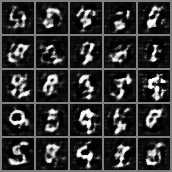


Epoch: 1/20, batch: 400/469, G_loss: 2.0613174438476562, D_loss: 0.4385259449481964


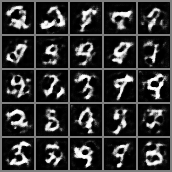

KeyboardInterrupt: 

In [ ]:
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)

for epoch in range(hparams['num_epochs']):

    for i, (real_samples, labels) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        loss_g, loss_d = train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d)

        if (i+1) % 200 == 0:
            print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
                  +f" G_loss: {loss_g}, D_loss: {loss_d}")

            fake_images = evaluate(generator, z_val)
            display(fake_images)

    print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
          +f" G_loss: {loss_g}, D_loss: {loss_d}")

    fake_images = evaluate(generator, z_val)
    display(fake_images)


# Extra: Conditional GAN

### Exercise 4: Generator

We will now modify the generator from before to a conditional generator. To do it, we will concatenate the input to the convolutions with an embedding of the label we want to generate.

Complete the forward method. To do it, use the embedding layer with the label, and then use `torch.cat` to concatenate the label as a channel (after the corresponding `reshape`)

**Hint**: The embedding is concatenated as a new channel.

In [ ]:
class ConditionalGenerator(torch.nn.Module):

    def __init__(
            self,
            noise_size: int,
            num_input_channels: int,
            num_classes: int
            ) -> None:

        super().__init__()

        # TODO: Create the Fully connected layer using nn.Linear
        self.fc = nn.Linear(noise_size, 512*4*4, bias=False)

        # Embedding of the class
        self.embedding = nn.Embedding(
            num_embeddings=num_classes,
            embedding_dim=4*4,
        )

        # TODO: Create the first block
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(512+1, 256, kernel_size=4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # TODO: Create the second block
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # TODO: Create the third block using nn.Sequential with ConvTranspose2d, and activation
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(128, num_input_channels, kernel_size=4, stride=2, padding=1, bias=False), # (B, num_input_channels, 32, 32)
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor, label: int) -> torch.Tensor:

        # TODO: Define the forward of the generator, x are random noise vectors (B, noise_size)
        x = self.fc(x)
        x = x.reshape(-1, 512, 4, 4) # (B, channels, height, width)
        emb = self.embedding(label).reshape(-1, 1, 4, 4) # (B, 1, height, width)
        x = torch.cat([x,emb], dim=1)

        x = self.convt1(x)  # (B, 256, 8, 8)
        x = self.convt2(x)  # (B, 128, 16, 16)
        x = self.convt3(x)  # (B, num_input_channels, 32, 32)

        return x

### Exercise 5: Discriminator

We will now modify the discriminator from before to a conditional discriminator. To do it, we will concatenate the input image with an embedding of the label we want to generate.

Complete the forward method. To do it, use the embedding layer with the label, and then use `torch.cat` to concatenate the label as a channel (after the corresponding `reshape`)

**Hint**: The embedding is concatenated as a new channel.

In [ ]:
class ConditionalDiscriminator(torch.nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 num_classes: int):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=num_classes,
            embedding_dim=32*32,
        )

        # TODO: Create the first block
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_input_channels + 1,  # Extra channel for label
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),  # (B, 128, 16, 16)
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),  # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )


        # TODO: Create the third block
        self.conv3 = nn.Sequential(
              nn.Conv2d(
                  in_channels=256,
                  out_channels=512,
                  kernel_size=4,
                  stride=2,
                  padding=1,
                  bias=False
              ),  # (B, 512, 4, 4)
              nn.BatchNorm2d(512),
              nn.LeakyReLU(0.2),
          )

        # TODO: Create the fully connected block using nn.Sequential with Linear and activation
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),  # Single output for binary classification
            nn.Sigmoid(),  # Output in range [0, 1]
        )

    def forward(self, x: torch.Tensor, label: int) -> torch.Tensor:
        # TODO: Define the forward of the discriminator, x are images (B, num_input_channels, 32, 32)
        emb = self.embedding(label).reshape(-1, 1, 32, 32)  # (B, 1, 32, 32)

        # Concatenate image and embedding along channel dimension
        x = torch.cat([x, emb], dim=1)  # (B, num_input_channels + 1, 32, 32)

        # Pass through convolutional blocks
        x = self.conv1(x)  # (B, 128, 16, 16)
        x = self.conv2(x)  # (B, 256, 8, 8)
        x = self.conv3(x)  # (B, 512, 4, 4)

        # Flatten and pass through fully connected layer
        x = x.reshape(-1, 512 * 4 * 4)  # (B, 512 * 4 * 4)
        x = self.fc(x)  # (B, 1)

        return x


In [ ]:
generator = ConditionalGenerator(hparams['noise_size'], hparams['num_input_channels'],
                                 hparams['num_classes']).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'],
                               betas=hparams['betas'])

discriminator = ConditionalDiscriminator(hparams['num_input_channels'],hparams['num_classes']).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

criterion = nn.BCELoss()

def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);


## Train function

In [ ]:
def train_batch_conditional(
        real_samples: torch.Tensor,
        real_classes: torch.Tensor,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        optimizer_g: torch.optim,
        optimizer_d: torch.optim,
        ) -> Tuple[float, float]:

    generator.train()
    discriminator.train()

    bsz = real_samples.shape[0]

    # TODO: Define the labels for the real (ones) and fake (zeros) images of size (bsz, 1)
    label_real = torch.ones(bsz, 1)
    label_fake = torch.zeros(bsz, 1)

    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(bsz, hparams['noise_size'], device=device)
    fake_classes = torch.randint(0, 10, size=(bsz, 1), device=device)
    fake_samples = generator(z, fake_classes)

    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples, fake_classes)

    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real)

    # Backpropagate
    loss_g.backward()

    # Update weights
    optimizer_g.step()

    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################

    fake_samples = fake_samples.detach()

    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples, real_classes)

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real)

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples, fake_classes)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake)

    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2

    # Backpropagate
    loss_d.backward()

    # Update weights
    optimizer_d.step()

    return loss_g.item(), loss_d.item()


## Evaluation function

In [ ]:
@torch.no_grad()
def evaluate_conditional(
        generator: torch.nn.Module,
        z_val: torch.Tensor,
        labels_val: torch.Tensor,
        ) -> Image.Image:

    generator.eval()
    fake_samples = generator(z_val, labels_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img*0.5 + 0.5)*255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    return Image.fromarray(image_numpy)


## Train loop


Epoch: 1/20, batch: 200/469, G_loss: 4.2641282081604, D_loss: 0.09021561592817307


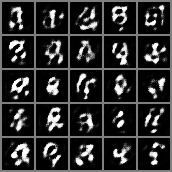


Epoch: 1/20, batch: 400/469, G_loss: 5.851240158081055, D_loss: 0.013538319617509842


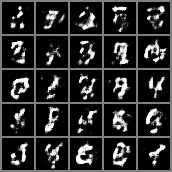


Epoch: 1/20, batch: 469/469, G_loss: 3.1360716819763184, D_loss: 0.04253605008125305


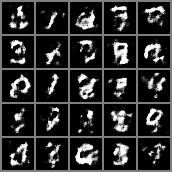


Epoch: 2/20, batch: 200/469, G_loss: 3.909128189086914, D_loss: 0.20196282863616943


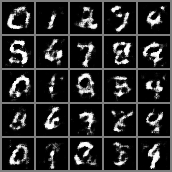


Epoch: 2/20, batch: 400/469, G_loss: 4.697192668914795, D_loss: 0.6463452577590942


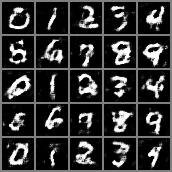


Epoch: 2/20, batch: 469/469, G_loss: 1.2031418085098267, D_loss: 0.29351645708084106


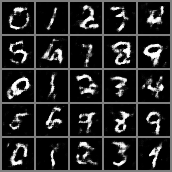


Epoch: 3/20, batch: 200/469, G_loss: 1.5613911151885986, D_loss: 0.26379695534706116


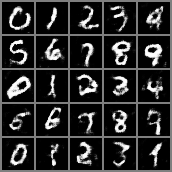


Epoch: 3/20, batch: 400/469, G_loss: 1.7319767475128174, D_loss: 0.15690204501152039


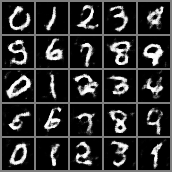


Epoch: 3/20, batch: 469/469, G_loss: 2.0268335342407227, D_loss: 0.23162922263145447


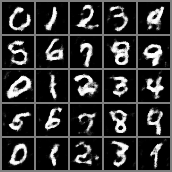


Epoch: 4/20, batch: 200/469, G_loss: 1.259523630142212, D_loss: 0.2514868974685669


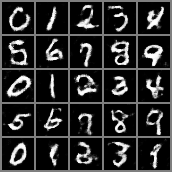


Epoch: 4/20, batch: 400/469, G_loss: 4.430123329162598, D_loss: 0.19012174010276794


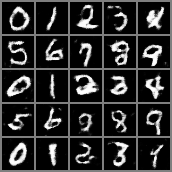


Epoch: 4/20, batch: 469/469, G_loss: 1.437234878540039, D_loss: 0.2260276824235916


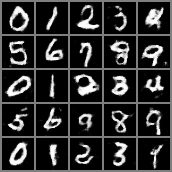


Epoch: 5/20, batch: 200/469, G_loss: 3.498595714569092, D_loss: 0.17326326668262482


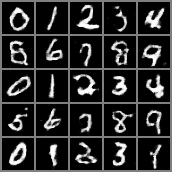


Epoch: 5/20, batch: 400/469, G_loss: 4.073296546936035, D_loss: 0.18011321127414703


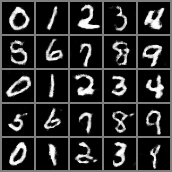


Epoch: 5/20, batch: 469/469, G_loss: 3.206571102142334, D_loss: 0.1460144817829132


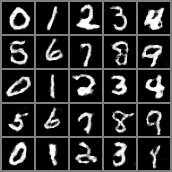


Epoch: 6/20, batch: 200/469, G_loss: 2.24741792678833, D_loss: 0.09706133604049683


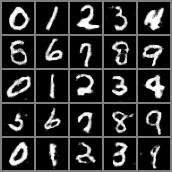


Epoch: 6/20, batch: 400/469, G_loss: 3.246598243713379, D_loss: 0.03845532238483429


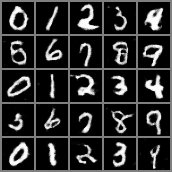


Epoch: 6/20, batch: 469/469, G_loss: 4.342577934265137, D_loss: 0.03950953856110573


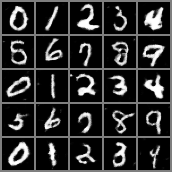


Epoch: 7/20, batch: 200/469, G_loss: 3.3610897064208984, D_loss: 0.07582195848226547


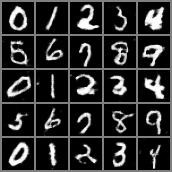


Epoch: 7/20, batch: 400/469, G_loss: 4.076372146606445, D_loss: 0.01673411950469017


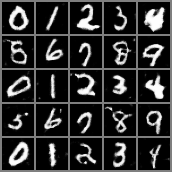


Epoch: 7/20, batch: 469/469, G_loss: 1.9400889873504639, D_loss: 0.12435987591743469


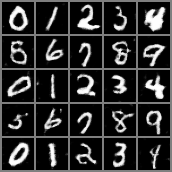


Epoch: 8/20, batch: 200/469, G_loss: 5.8098578453063965, D_loss: 0.02086000144481659


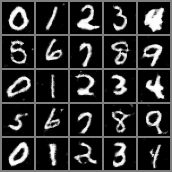


Epoch: 8/20, batch: 400/469, G_loss: 4.676147937774658, D_loss: 0.008687593042850494


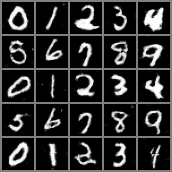


Epoch: 8/20, batch: 469/469, G_loss: 4.977276802062988, D_loss: 0.009074261412024498


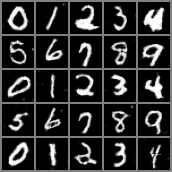


Epoch: 9/20, batch: 200/469, G_loss: 5.123911380767822, D_loss: 0.008415923453867435


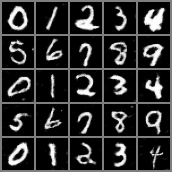


Epoch: 9/20, batch: 400/469, G_loss: 5.640969276428223, D_loss: 0.008268840610980988


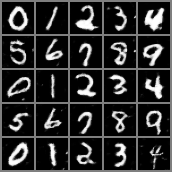


Epoch: 9/20, batch: 469/469, G_loss: 5.666460990905762, D_loss: 0.003961481153964996


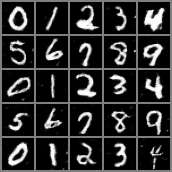


Epoch: 10/20, batch: 200/469, G_loss: 5.63092041015625, D_loss: 0.004099689424037933


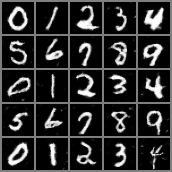


Epoch: 10/20, batch: 400/469, G_loss: 1.1250815391540527, D_loss: 0.39373889565467834


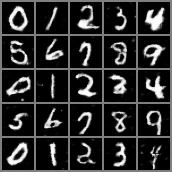


Epoch: 10/20, batch: 469/469, G_loss: 0.700643002986908, D_loss: 0.5542797446250916


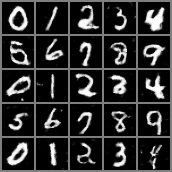


Epoch: 11/20, batch: 200/469, G_loss: 2.4678468704223633, D_loss: 0.13660062849521637


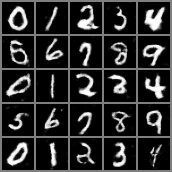


Epoch: 11/20, batch: 400/469, G_loss: 3.364959955215454, D_loss: 0.04732874780893326


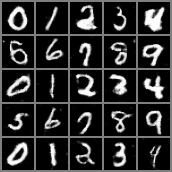


Epoch: 11/20, batch: 469/469, G_loss: 4.248334884643555, D_loss: 0.0184159055352211


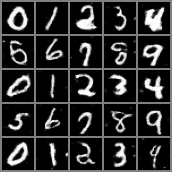


Epoch: 12/20, batch: 200/469, G_loss: 4.814964294433594, D_loss: 0.008917960338294506


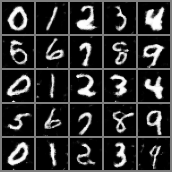


Epoch: 12/20, batch: 400/469, G_loss: 5.18165397644043, D_loss: 0.008715463802218437


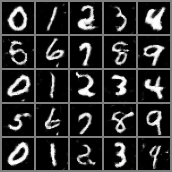


Epoch: 12/20, batch: 469/469, G_loss: 5.94964599609375, D_loss: 0.004219310823827982


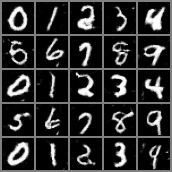


Epoch: 13/20, batch: 200/469, G_loss: 5.844220161437988, D_loss: 0.004169047344475985


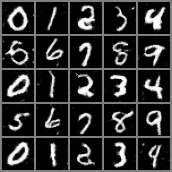


Epoch: 13/20, batch: 400/469, G_loss: 6.335816860198975, D_loss: 0.002748974831774831


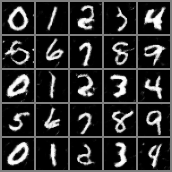


Epoch: 13/20, batch: 469/469, G_loss: 6.737093925476074, D_loss: 0.004201258532702923


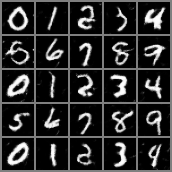


Epoch: 14/20, batch: 200/469, G_loss: 6.877781867980957, D_loss: 0.001789935166016221


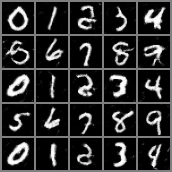


Epoch: 14/20, batch: 400/469, G_loss: 5.932071685791016, D_loss: 0.003469370771199465


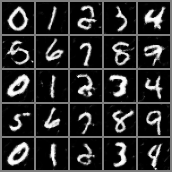


Epoch: 14/20, batch: 469/469, G_loss: 6.553340435028076, D_loss: 0.0018546743085607886


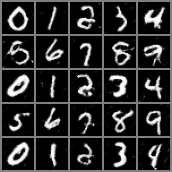


Epoch: 15/20, batch: 200/469, G_loss: 7.225366592407227, D_loss: 0.001484138541854918


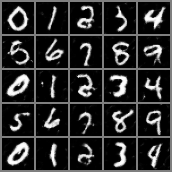


Epoch: 15/20, batch: 400/469, G_loss: 6.60495662689209, D_loss: 0.0015417191898450255


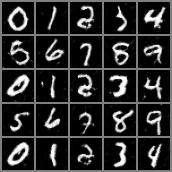


Epoch: 15/20, batch: 469/469, G_loss: 6.4734907150268555, D_loss: 0.0022554718889296055


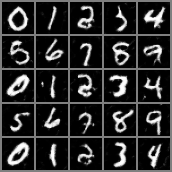


Epoch: 16/20, batch: 200/469, G_loss: 8.361368179321289, D_loss: 0.0009369557956233621


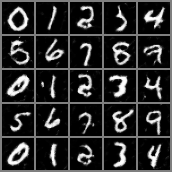


Epoch: 16/20, batch: 400/469, G_loss: 7.325847148895264, D_loss: 0.0010234295623376966


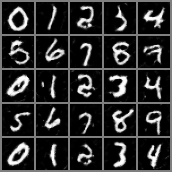


Epoch: 16/20, batch: 469/469, G_loss: 6.965824127197266, D_loss: 0.0019141623051837087


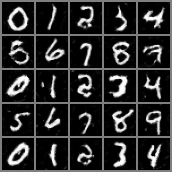


Epoch: 17/20, batch: 200/469, G_loss: 7.991205215454102, D_loss: 0.0010166359134018421


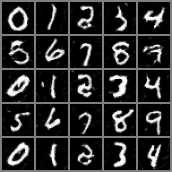


Epoch: 17/20, batch: 400/469, G_loss: 0.0, D_loss: 50.0


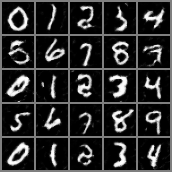


Epoch: 17/20, batch: 469/469, G_loss: 0.0, D_loss: 50.0


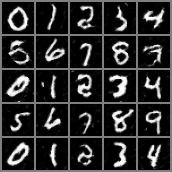


Epoch: 18/20, batch: 200/469, G_loss: 0.0, D_loss: 50.0


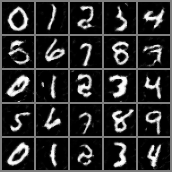


Epoch: 18/20, batch: 400/469, G_loss: 0.0, D_loss: 50.0


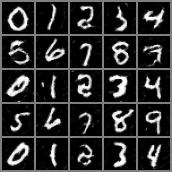


Epoch: 18/20, batch: 469/469, G_loss: 0.0, D_loss: 50.0


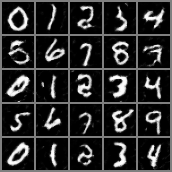


Epoch: 19/20, batch: 200/469, G_loss: 0.0, D_loss: 50.0


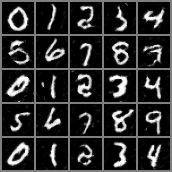


Epoch: 19/20, batch: 400/469, G_loss: 0.0, D_loss: 50.0


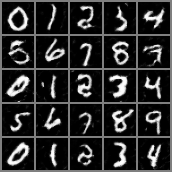


Epoch: 19/20, batch: 469/469, G_loss: 0.0, D_loss: 50.0


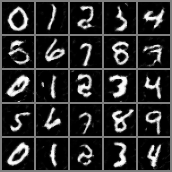


Epoch: 20/20, batch: 200/469, G_loss: 0.0, D_loss: 50.0


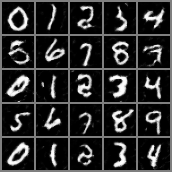


Epoch: 20/20, batch: 400/469, G_loss: 0.0, D_loss: 50.0


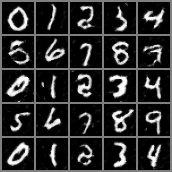


Epoch: 20/20, batch: 469/469, G_loss: 0.0, D_loss: 50.0


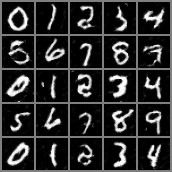

In [ ]:
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)
labels_cycle = cycle(range(hparams['num_classes']))
labels_val = torch.tensor([next(labels_cycle) for i in range(hparams['num_val_samples'])],
                          device=device).unsqueeze(1) #the labels will be a cycle from 0 to 9

for epoch in range(hparams['num_epochs']):

    for i, (real_samples, real_classes) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        real_classes = real_classes.unsqueeze(1).to(device)
        loss_g, loss_d = train_batch_conditional(
            real_samples,
            real_classes,
            generator,
            discriminator,
            optimizer_g,
            optimizer_d,
        )

        if (i+1) % 200 == 0:
            print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
                  + f" G_loss: {loss_g}, D_loss: {loss_d}")

            fake_images = evaluate_conditional(generator, z_val, labels_val)
            display(fake_images)

    print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)}, "
          + f"G_loss: {loss_g}, D_loss: {loss_d}")

    fake_images = evaluate_conditional(generator, z_val, labels_val)
    display(fake_images)


### Conditional generation

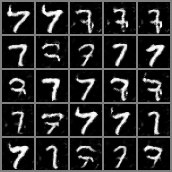

In [ ]:
#You can play and visualize different numbers
number_chosen = 7
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)
number_chosen_torch = torch.tensor([
        number_chosen for i in range(hparams['num_val_samples'])
    ],
    device=device).unsqueeze(1)

images_number_chosen = evaluate_conditional(generator, z_val, number_chosen_torch)
display(images_number_chosen)